# Import Packages

In [1]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as keras_layer, Sequential, optimizers, losses, callbacks
from tensorflow.keras.losses import mae, mse, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, f1_score, accuracy_score, mean_squared_log_error, mean_absolute_percentage_error, median_absolute_error, explained_variance_score, balanced_accuracy_score, precision_score, recall_score, matthews_corrcoef
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, SVC, NuSVC, LinearSVC
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os
import sklearn
import skimage
import glob
import random
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
tf.__version__

'2.18.0'

# Import Data From Kaggle

In [3]:
!chmod 600 ~/ /content/drive/MyDrive/Hackathons/kaggle

In [4]:
!kaggle datasets download -d ultralytics/signature

Dataset URL: https://www.kaggle.com/datasets/ultralytics/signature
License(s): GNU Affero General Public License 3.0
 44% 5.00M/11.3M [00:00<00:00, 34.7MB/s]
100% 11.3M/11.3M [00:00<00:00, 54.2MB/s]


In [5]:
!unzip /content/signature.zip

Archive:  /content/signature.zip
  inflating: LICENSE.txt             
  inflating: data.yaml               
  inflating: train/images/Frame_100.jpg  
  inflating: train/images/Frame_102.jpg  
  inflating: train/images/Frame_104.jpg  
  inflating: train/images/Frame_106.jpg  
  inflating: train/images/Frame_110.jpg  
  inflating: train/images/Frame_112.jpg  
  inflating: train/images/Frame_114.jpg  
  inflating: train/images/Frame_116.jpg  
  inflating: train/images/Frame_118.jpg  
  inflating: train/images/Frame_120.jpg  
  inflating: train/images/Frame_122.jpg  
  inflating: train/images/Frame_124.jpg  
  inflating: train/images/Frame_126.jpg  
  inflating: train/images/Frame_128.jpg  
  inflating: train/images/Frame_130.jpg  
  inflating: train/images/Frame_136.jpg  
  inflating: train/images/Frame_138.jpg  
  inflating: train/images/Frame_140.jpg  
  inflating: train/images/Frame_142.jpg  
  inflating: train/images/Frame_144.jpg  
  inflating: train/images/Frame_146.jpg  
  inflati

# Model That Will Be Experiment On This Dataset

1. CNN Model ( Baseline )
2. Deep CNN with Data Augmentation

# Preprocessing Imported Data

In [6]:
IMAGE_SIZE = (224, 224)

In [7]:
224 / 8

28.0

## Load And Resize Image

In [8]:
def load_and_resize_image(image_path):
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, IMAGE_SIZE)

  return img

array([[[125, 118, 115],
        [123, 117, 113],
        [132, 125, 122],
        ...,
        [159, 160, 156],
        [153, 154, 150],
        [148, 148, 144]],

       [[131, 124, 121],
        [131, 124, 121],
        [139, 132, 129],
        ...,
        [159, 160, 156],
        [151, 152, 148],
        [148, 149, 145]],

       [[135, 128, 125],
        [135, 128, 125],
        [137, 130, 127],
        ...,
        [155, 156, 152],
        [148, 149, 145],
        [146, 147, 143]],

       ...,

       [[127, 115, 113],
        [125, 113, 111],
        [127, 115, 113],
        ...,
        [ 91,  81,  74],
        [ 91,  81,  74],
        [ 89,  79,  72]],

       [[127, 115, 113],
        [127, 115, 113],
        [127, 115, 113],
        ...,
        [ 91,  79,  77],
        [ 89,  79,  72],
        [ 90,  80,  74]],

       [[127, 115, 113],
        [127, 115, 113],
        [127, 115, 113],
        ...,
        [ 91,  79,  77],
        [ 92,  82,  75],
        [ 91,  81,  74]]], dtype=uint8)
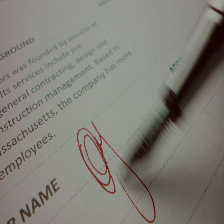

In [9]:
load_image = load_and_resize_image("/content/valid/images/Frame_108.jpg")
load_image

## Load And Process Label

In [260]:
def load_and_process_label(label_path):
  with open(label_path, "r") as file:
    lines = file.readlines()

    label_values = [list(map(float, label.strip().split())) for label in lines]
    label_array = np.array(label_values).flatten()

    return label_array[1:]

In [261]:
load_label = load_and_process_label("/content/valid/labels/Frame_108.txt")
load_label

array([0.51875 , 0.769907, 0.3625  , 0.460185])

## Make Draw Bounding Box

In [264]:
def draw_ground_truth_box(img, label, color = (0, 0, 255)):
    class_id = int(label[0])

    x_center, y_center, width, height = map(float, label)

    img_w, img_h = IMAGE_SIZE
    x_center, y_center = int(x_center * img_w), int(y_center * img_h)
    width, height = int(width * img_w), int(height * img_h)

    x1, y1 = x_center - width // 2, y_center - height // 2
    x2, y2 = x_center + width // 2, y_center + height // 2

    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

array([[[125, 118, 115],
        [123, 117, 113],
        [132, 125, 122],
        ...,
        [159, 160, 156],
        [153, 154, 150],
        [148, 148, 144]],

       [[131, 124, 121],
        [131, 124, 121],
        [139, 132, 129],
        ...,
        [159, 160, 156],
        [151, 152, 148],
        [148, 149, 145]],

       [[135, 128, 125],
        [135, 128, 125],
        [137, 130, 127],
        ...,
        [155, 156, 152],
        [148, 149, 145],
        [146, 147, 143]],

       ...,

       [[127, 115, 113],
        [125, 113, 111],
        [127, 115, 113],
        ...,
        [ 91,  81,  74],
        [ 91,  81,  74],
        [ 89,  79,  72]],

       [[127, 115, 113],
        [127, 115, 113],
        [127, 115, 113],
        ...,
        [ 91,  79,  77],
        [ 89,  79,  72],
        [ 90,  80,  74]],

       [[127, 115, 113],
        [127, 115, 113],
        [127, 115, 113],
        ...,
        [ 91,  79,  77],
        [ 92,  82,  75],
        [ 91,  81,  74]]], dtype=uint8)
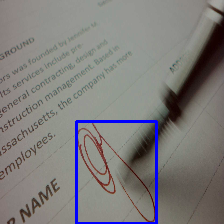

In [265]:
demo_draw_ground = draw_ground_truth_box(
    load_image,
    load_label
)

demo_draw_ground

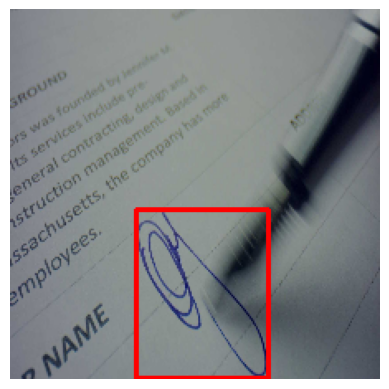

In [266]:
plt.imshow(cv2.cvtColor(demo_draw_ground, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show();

## Histogram of Oriented Gradients

In [267]:
def extract_hog_feature(image_data):

  image = np.array(image_data, dtype = np.uint8)

  features, _ = skimage.feature.hog(
      image,
      pixels_per_cell=(16, 16),
      cells_per_block=(2, 2),
      visualize=True
      )

  return features

## Oriented First And Rotated BRIEF

In [268]:
def extract_orb_feature(image):
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(image, None)

  return descriptors.flatten() if descriptors is not None else np.zeros(128)

## Define Train And Valid Directory

In [269]:
images_train_dir = "/content/train/images"
labels_train_dir = "/content/train/labels"

images_valid_dir = "/content/valid/images"
labels_valid_dir = "/content/valid/labels"

## Glob The Train And Val Data

In [270]:
def get_image_labels_pairs(image_dir, label_dir):
  image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
  label_paths = sorted(glob.glob(os.path.join(label_dir, "*.txt")))

  image_label_pairs = []
  for img_path in image_paths:
    base_name = os.path.basename(img_path).split('.')[0]

    label_path = os.path.join(label_dir, base_name + ".txt")

    image_label_pairs.append((
      load_and_resize_image(img_path),
      load_and_process_label(label_path)
    ))

  return image_label_pairs

In [271]:
train_data = get_image_labels_pairs(
    images_train_dir,
    labels_train_dir
)

In [272]:
len(train_data)

143

In [273]:
val_data = get_image_labels_pairs(
    images_valid_dir,
    labels_valid_dir
)

In [274]:
len(val_data)

35

## Split The Images And Trains Data

In [275]:
train_images, train_labels = zip(*train_data)

In [276]:
train_images = np.array(train_images).astype(np.float32) / 255.0
train_labels = np.array(train_labels).astype(np.float32)

In [277]:
len(train_images), len(train_labels)

(143, 143)

In [278]:
val_images, val_labels = zip(*val_data)

In [279]:
val_images = np.array(val_images).astype(np.float32) / 255.0
val_labels = np.array(val_labels).astype(np.float32)

In [280]:
len(val_images), len(val_labels)

(35, 35)

## Visualized The Data

In [281]:
train_images[0], train_labels[0]

(array([[[0.49803922, 0.47058824, 0.45882353],
         [0.4862745 , 0.45882353, 0.44705883],
         [0.5254902 , 0.49803922, 0.4862745 ],
         ...,
         [0.08235294, 0.00784314, 0.01960784],
         [0.09803922, 0.05098039, 0.05098039],
         [0.11372549, 0.05098039, 0.09411765]],
 
        [[0.52156866, 0.49411765, 0.48235294],
         [0.5254902 , 0.49803922, 0.4862745 ],
         [0.5372549 , 0.50980395, 0.49803922],
         ...,
         [0.11372549, 0.03529412, 0.05098039],
         [0.10980392, 0.0627451 , 0.0627451 ],
         [0.12941177, 0.06666667, 0.10980392]],
 
        [[0.5294118 , 0.5019608 , 0.49019608],
         [0.5294118 , 0.5019608 , 0.49019608],
         [0.5372549 , 0.50980395, 0.49803922],
         ...,
         [0.12156863, 0.04705882, 0.05882353],
         [0.1254902 , 0.07843138, 0.07843138],
         [0.15294118, 0.08627451, 0.13333334]],
 
        ...,
 
        [[0.49803922, 0.4509804 , 0.44313726],
         [0.49803922, 0.4509804 , 0.44313

In [282]:
val_images[0], val_labels[0]

(array([[[0.49019608, 0.4627451 , 0.4509804 ],
         [0.48235294, 0.45882353, 0.44313726],
         [0.5176471 , 0.49019608, 0.47843137],
         ...,
         [0.62352943, 0.627451  , 0.6117647 ],
         [0.6       , 0.6039216 , 0.5882353 ],
         [0.5803922 , 0.5803922 , 0.5647059 ]],
 
        [[0.5137255 , 0.4862745 , 0.4745098 ],
         [0.5137255 , 0.4862745 , 0.4745098 ],
         [0.54509807, 0.5176471 , 0.5058824 ],
         ...,
         [0.62352943, 0.627451  , 0.6117647 ],
         [0.5921569 , 0.59607846, 0.5803922 ],
         [0.5803922 , 0.58431375, 0.5686275 ]],
 
        [[0.5294118 , 0.5019608 , 0.49019608],
         [0.5294118 , 0.5019608 , 0.49019608],
         [0.5372549 , 0.50980395, 0.49803922],
         ...,
         [0.60784316, 0.6117647 , 0.59607846],
         [0.5803922 , 0.58431375, 0.5686275 ],
         [0.57254905, 0.5764706 , 0.56078434]],
 
        ...,
 
        [[0.49803922, 0.4509804 , 0.44313726],
         [0.49019608, 0.44313726, 0.43529

## Plot Random 3

In [283]:
def plot_random_image(images, labels, show = 5, range_len = 10):
  random_indices = random.sample(range(0, range_len), show)
  fig, axes = plt.subplots(1, show, figsize=(15, 5))

  for i, idx in enumerate(random_indices):
      random_draw_ground = draw_ground_truth_box(images[idx], labels[idx])

      axes[i].imshow(cv2.cvtColor(random_draw_ground, cv2.COLOR_BGR2RGB))
      axes[i].axis("off")

  plt.show()

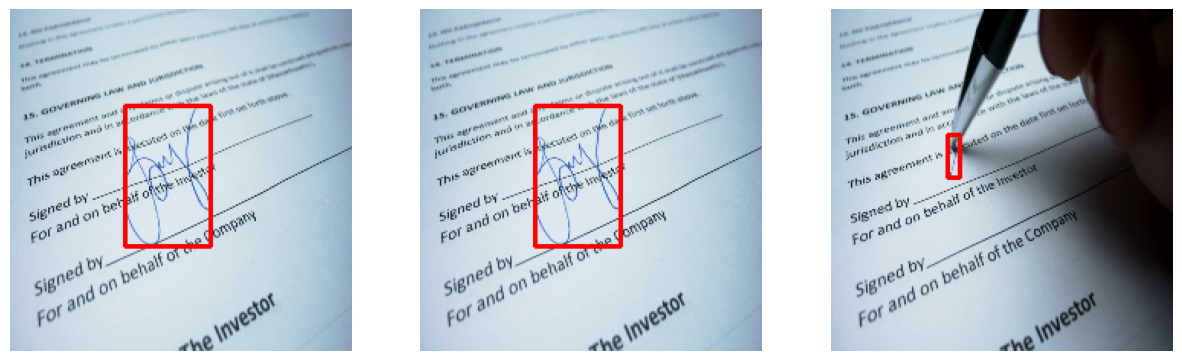

In [284]:
plot_random_image(train_images, train_labels, show = 3, range_len=142)

# View Shapes

In [285]:
train_images.shape

(143, 224, 224, 3)

In [286]:
train_labels.shape

(143, 4)

In [287]:
val_images.shape

(35, 224, 224, 3)

In [288]:
val_labels.shape

(35, 4)

# Model 1: CNN ( Baseline )

In [341]:
model_1 = Sequential([
    keras_layer.Input(shape=(224, 224, 3)),
    keras_layer.Conv2D(256, 3, activation="relu", padding = "same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(256, 3, activation="relu", padding = "same"),
    keras_layer.MaxPool2D(),
    keras_layer.Conv2D(256, 3, activation="relu", padding = "same"),
    keras_layer.MaxPool2D(),
    keras_layer.GlobalAveragePooling2D(),
    keras_layer.Dense(512, activation = "relu"),
    keras_layer.Dropout(0.5),
    keras_layer.Dense(4, activation="linear")
])

In [342]:
model_1.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_162 (Conv2D)                  │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_141 (MaxPooling2D)     │ (None, 112, 112, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_163 (Conv2D)                  │ (None, 112, 112, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_142 (MaxPooling2D)     │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_164 (Conv2D)                  │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_143 (MaxPooling2D)     │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_15          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320,964 (5.04 MB)

 Trainable params: 1,320,964 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [343]:
model_1.compile(
    loss = losses.huber,
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy", "mae"]
)

In [344]:
history_model_1 = model_1.fit(
    train_images,
    train_labels,
    epochs = 20,
    batch_size = 8
)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 670ms/step - accuracy: 0.7127 - loss: 0.0761 - mae: 0.3190
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.6253 - loss: 0.0466 - mae: 0.1943
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5237 - loss: 0.0235 - mae: 0.1653
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5921 - loss: 0.0241 - mae: 0.1589
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5061 - loss: 0.0211 - mae: 0.1489
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.7081 - loss: 0.0247 - mae: 0.1489
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7075 - loss: 0.0175 - mae: 0.1416
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7047 - loss: 0.0180 - mae: 0.1465
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7131 - loss: 0.0161 - mae: 0.1347
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7462 - loss: 0.0138 - mae: 0.1238
Epoch 

In [345]:
model_1.evaluate(val_images, val_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8527 - loss: 0.0093 - mae: 0.1107


[0.009299850091338158, 0.8571428656578064, 0.11066228151321411]

In [346]:
model_1_preds_probs = model_1.predict(val_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step


In [347]:
model_1_preds_probs[:5]

array([[0.5038251 , 0.65228933, 0.28467742, 0.5105224 ],
       [0.50295055, 0.650422  , 0.2838857 , 0.50840753],
       [0.5110798 , 0.661282  , 0.28959015, 0.51881003],
       [0.51940733, 0.67550844, 0.29784694, 0.5268784 ],
       [0.5195239 , 0.67554253, 0.29790977, 0.52694196]], dtype=float32)

In [348]:
val_labels[:5]

array([[0.51875 , 0.769907, 0.3625  , 0.460185],
       [0.516406, 0.765741, 0.367188, 0.468519],
       [0.517188, 0.656019, 0.365625, 0.687963],
       [0.517708, 0.569907, 0.364583, 0.860185],
       [0.517708, 0.569907, 0.364583, 0.860185]], dtype=float32)

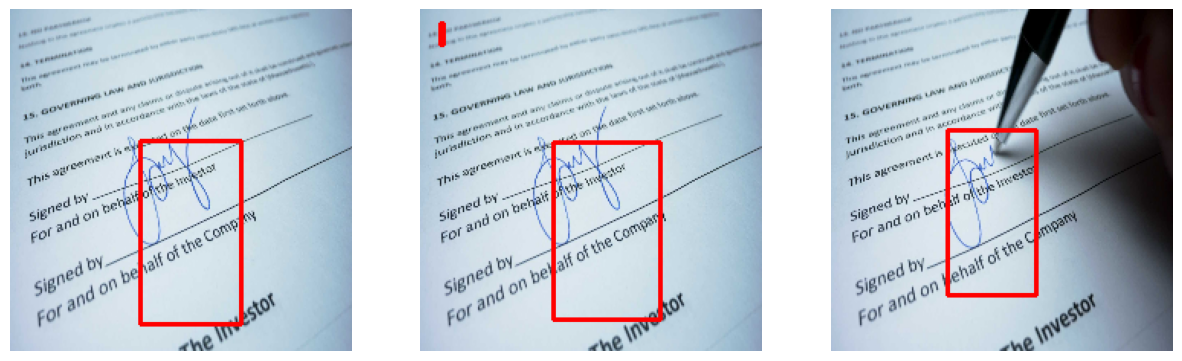

In [349]:
plot_random_image(val_images, model_1_preds_probs, show=3, range_len=30)

# Model 2: Deep CNN + Data Argumentation

In [299]:
data_argumentation = Sequential([
    keras_layer.RandomFlip("horizontal_and_vertical"),
    keras_layer.RandomBrightness(0.2),
    keras_layer.RandomHeight(0.2),
    keras_layer.RandomRotation(0.2),
    keras_layer.RandomWidth(0.2),
    keras_layer.RandomZoom(0.2),
    keras_layer.RandomContrast(0.2),
    keras_layer.RandomSaturation(0.2),
])

In [300]:
data_argumentation.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness_6                  │ ?                           │     0 (unbuilt) │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_height_8 (RandomHeight)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_8 (RandomRotation)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_width_8 (RandomWidth)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_8 (RandomZoom)           │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_6 (RandomContrast)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_saturation_6                  │ ?                           │     0 (unbuilt) │
│ (RandomSaturation)                   │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [306]:
inputs = keras_layer.Input(shape= (224, 224, 3))
x = data_argumentation(inputs)
x = keras_layer.Conv2D(32, 3, activation = "relu", padding = "same")(x)
x = keras_layer.MaxPool2D()(x)
x = keras_layer.Conv2D(64, 3, activation = "relu", padding = "same")(x)
x = keras_layer.MaxPool2D()(x)
x = keras_layer.Conv2D(128, 3, activation = "relu", padding = "same")(x)
x = keras_layer.MaxPool2D()(x)
x = keras_layer.GlobalAveragePooling2D()(x)
x = keras_layer.Dense(128, activation= "relu")(x)
outputs = keras_layer.Dense(4, activation = "linear")(x)

model_2 = keras.Model(inputs, outputs)

In [307]:
model_2.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_65 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_24 (Sequential)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_150 (Conv2D)                  │ (None, None, None, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_129 (MaxPooling2D)     │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_151 (Conv2D)                  │ (None, None, None, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_130 (MaxPooling2D)     │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_152 (Conv2D)                  │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_131 (MaxPooling2D)     │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,276 (430.77 KB)

 Trainable params: 110,276 (430.77 KB)

 Non-trainable params: 0 (0.00 B)

In [308]:
model_2.compile(
    loss = losses.huber,
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy", "mae"]
)

In [309]:
hisotry_model_2 = model_2.fit(
    train_images,
    train_labels,
    epochs = 10,
    batch_size = 16
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - accuracy: 0.1294 - loss: 3.0988 - mae: 3.4851
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.4120 - loss: 0.5977 - mae: 0.9296
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 0.3877 - loss: 0.2376 - mae: 0.5501
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.6677 - loss: 0.0950 - mae: 0.3562
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step - accuracy: 0.6624 - loss: 0.0761 - mae: 0.3433
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.5901 - loss: 0.0771 - mae: 0.3380
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.5738 - loss: 0.0751 - mae: 0.3361
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.7215 - loss: 0.0796 - mae: 0.3514
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.7450 - loss: 0.0687 - mae: 0.3258
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 383ms/step - accuracy: 0.6436 - loss: 0.0594 - mae: 0.2940


In [310]:
model_2.evaluate(val_images, val_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8527 - loss: 0.0933 - mae: 0.3769 


[0.09294374287128448, 0.8571428656578064, 0.3764078915119171]

In [311]:
model_2_preds = model_2.predict(val_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


In [315]:
model_2_preds[:5]

array([[0.05854756, 0.07706789, 0.00307621, 0.05700295],
       [0.05880253, 0.07765625, 0.00336727, 0.05703471],
       [0.058086  , 0.07670606, 0.00363551, 0.05715688],
       [0.05790785, 0.07666427, 0.00379368, 0.05709312],
       [0.05792641, 0.07661832, 0.00378639, 0.05718639]], dtype=float32)

In [316]:
val_labels[:5]

array([[0.51875 , 0.769907, 0.3625  , 0.460185],
       [0.516406, 0.765741, 0.367188, 0.468519],
       [0.517188, 0.656019, 0.365625, 0.687963],
       [0.517708, 0.569907, 0.364583, 0.860185],
       [0.517708, 0.569907, 0.364583, 0.860185]], dtype=float32)

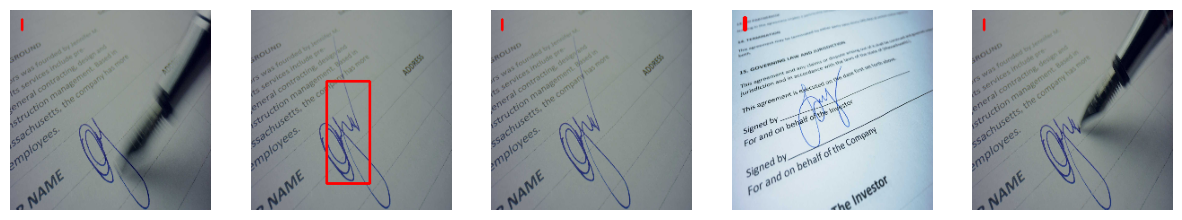

In [319]:
plot_random_image(val_images, model_2_preds, 5, 30)

> Note: Object Detection Not Perform Good In Data Argumentation